In [1]:
import numpy as np
import wfdb
import os
import logging
import warnings

# --- 1. SILENCE TENSORFLOW & CUDA WARNINGS ---
# 2 = Error/Warning only (Suppresses Info)
# 3 = Error only (Suppresses Warnings & Info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Silence Python warnings
warnings.filterwarnings("ignore")

# Silence TensorFlow internal logger
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)


from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, MaxPooling1D,
    Bidirectional, GRU, Dense, Dropout, Multiply, Flatten  # Swapped LSTM for GRU
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

In [2]:


# --- 1. GPU & CONFIGURATION ---
# Restart your kernel before running this!
DATA_PATH = '/workspace/physionet.org/files/mitdb/1.0.0/' 

# DEBUG MODE: Use only 6 records to ensure it runs. 
# Change to None later if you want the full dataset.
LIMIT_RECORDS = None

BATCH_SIZE = 32  # GRU is lighter, so 32 should be safe now
EPOCHS = 10      # Reduced epochs for a quick test run
WINDOW_SIZE = 360
AAMI_CLASSES = ['N', 'S', 'V', 'F', 'Q']

MIT_MAPPING = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N', 
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V', 'F': 'F', '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

ALL_RECORDS = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

In [3]:


# --- 2. METRICS & UTILS ---
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def load_records(record_list):
    X_list = []
    y_list = []
    for record_name in record_list:
        try:
            file_path = os.path.join(DATA_PATH, record_name)
            if not os.path.exists(file_path + '.dat'): continue
            record = wfdb.rdrecord(file_path)
            annotation = wfdb.rdann(file_path, 'atr')
            signal = record.p_signal[:, 0]
            beat_locs = annotation.sample
            beat_syms = annotation.symbol
            for loc, sym in zip(beat_locs, beat_syms):
                if sym in MIT_MAPPING:
                    if loc - 180 >= 0 and loc + 180 <= len(signal):
                        beat = signal[loc - 180 : loc + 180]
                        beat = (beat - np.mean(beat)) / (np.std(beat) + 1e-6)
                        label = AAMI_CLASSES.index(MIT_MAPPING[sym])
                        X_list.append(beat)
                        y_list.append(label)
        except Exception: pass
    return np.array(X_list), np.array(y_list, dtype=int)

In [4]:


# --- 3. THE LIGHTER MODEL (GRU) ---
def create_light_model(input_shape, nb_classes):
    inputs = Input(shape=input_shape)

    # CNN (Standard - kept as is because it's efficient)
    x = Conv1D(32, 5, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x); x = MaxPooling1D(2)(x)
    x = Conv1D(64, 5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x); x = MaxPooling1D(2)(x)
    
    # Reduced the third CNN layer to 64 filters (Lightweight)
    x = Conv1D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x); x = MaxPooling1D(2)(x); x = Dropout(0.3)(x)

    # --- THE CHANGE: GRU with Recurrent Dropout ---
    # 1. GRU uses less memory than LSTM.
    # 2. recurrent_dropout=0.1 disables the crashing CuDNN kernel.
    x = Bidirectional(GRU(32, return_sequences=True, recurrent_dropout=0.1))(x) 
    x = Dropout(0.3)(x)

    # Attention
    att = Dense(1, activation='tanh')(x); att = Flatten()(att)
    att = Activation('softmax')(att); att = tf.expand_dims(att, -1)
    context = Multiply()([x, att]); context = tf.reduce_sum(context, axis=1)

    # Head
    x = Dense(32, activation='relu')(context)
    x = Dropout(0.5)(x)
    outputs = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy', f1_metric])
    return model


In [5]:

# --- 4. EXECUTION ---
if __name__ == "__main__":
    if os.path.exists(DATA_PATH):
        # 1. LOAD DATA (Small Batch)
        records = ALL_RECORDS[:LIMIT_RECORDS] if LIMIT_RECORDS else ALL_RECORDS
        print(f"Running on {len(records)} records...")
        
        train_recs, test_recs = train_test_split(records, test_size=0.2, random_state=42)
        X_train, y_train_idx = load_records(train_recs)
        X_test, y_test_idx = load_records(test_recs)
        
        if len(X_train) > 0:
            print(f"Loaded {len(X_train)} beats for training.")
            X_train = X_train[..., np.newaxis]; X_test = X_test[..., np.newaxis]
            y_train = to_categorical(y_train_idx, 5); y_test = to_categorical(y_test_idx, 5)

            # 2. WEIGHTS
            y_ints = y_train_idx.astype(int)
            unique = np.unique(y_ints)
            weights = class_weight.compute_class_weight('balanced', classes=unique, y=y_ints)
            calc_weights = dict(zip(unique, weights))
            class_weights = {i: 1.0 for i in range(5)}
            class_weights.update(calc_weights)

            # 3. TRAIN
            strategy = tf.distribute.get_strategy()
            with strategy.scope():
                model = create_light_model((WINDOW_SIZE, 1), 5)
            
            print("Starting Training...")
            model.fit(
                X_train, y_train, validation_data=(X_test, y_test),
                epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights,
                callbacks=[EarlyStopping(patience=3, monitor='val_f1_metric', mode='max')]
            )
            
            print("\n--- Success! ---")
            y_pred = np.argmax(model.predict(X_test), axis=1)
            print(classification_report(y_test_idx, y_pred, target_names=AAMI_CLASSES))
        else:
            print("No data found.")
    else:
        print("Path incorrect.")

Running on 48 records...
Loaded 86936 beats for training.


I0000 00:00:1765040938.290841  107286 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765040938.389316  107286 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765040938.389348  107286 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765040938.396671  107286 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765040938.396700  107286 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Starting Training...
Epoch 1/10


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

   1/2717 [..............................] - ETA: 5:32:39 - loss: 2.1947 - accuracy: 0.0625 - f1_metric: 0.0000e+00

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1765040947.094429  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.094666  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.094878  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.095235  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.095592  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.095958  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.096154  107475 gpu_timer.cc:114] Skipping

   2/2717 [..............................] - ETA: 17:29 - loss: 1.6344 - accuracy: 0.0469 - f1_metric: 0.0000e+00  

W0000 00:00:1765040947.393874  107463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.394206  107463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.394402  107463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.395005  107463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.396435  107463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.397900  107463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.398428  107463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.399130  107463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.399441  107463 gp

   3/2717 [..............................] - ETA: 15:28 - loss: 1.3721 - accuracy: 0.0833 - f1_metric: 0.0000e+00

W0000 00:00:1765040947.746734  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.755050  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.755225  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.755461  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.755640  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.755857  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.756038  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.756277  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040947.756499  107469 gp

   4/2717 [..............................] - ETA: 14:47 - loss: 1.5085 - accuracy: 0.1016 - f1_metric: 0.0000e+00

W0000 00:00:1765040948.056867  107464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.057849  107464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.058000  107464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.058137  107464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.058243  107464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.058391  107464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.058510  107464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.058661  107464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.058808  107464 gp

   5/2717 [..............................] - ETA: 14:08 - loss: 1.5985 - accuracy: 0.1187 - f1_metric: 0.0000e+00

W0000 00:00:1765040948.327901  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.328940  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.329078  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.329233  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.329346  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.329515  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.329646  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.329798  107475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.329975  107475 gp

   6/2717 [..............................] - ETA: 13:47 - loss: 1.7263 - accuracy: 0.1250 - f1_metric: 0.0000e+00

W0000 00:00:1765040948.600123  107477 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.602453  107477 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.602594  107477 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.602756  107477 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.602861  107477 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.603009  107477 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.603142  107477 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.603295  107477 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.603471  107477 gp

   7/2717 [..............................] - ETA: 13:30 - loss: 1.7532 - accuracy: 0.1384 - f1_metric: 0.0000e+00

W0000 00:00:1765040948.876883  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.877772  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.877914  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.878068  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.878172  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.878320  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.878439  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.878591  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040948.878738  107462 gp

   8/2717 [..............................] - ETA: 13:23 - loss: 1.7400 - accuracy: 0.1523 - f1_metric: 0.0000e+00

W0000 00:00:1765040949.158615  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.159482  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.159626  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.159745  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.159852  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.160000  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.160121  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.160273  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.160421  107469 gp

   9/2717 [..............................] - ETA: 13:18 - loss: 1.7610 - accuracy: 0.1528 - f1_metric: 0.0000e+00

W0000 00:00:1765040949.451896  107461 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.452019  107461 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.452103  107461 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.452235  107461 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.452339  107461 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.452452  107461 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.452541  107461 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.452680  107461 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765040949.452821  107461 gp

2716/2717 [============================>.] - ETA: 0s - loss: 0.5786 - accuracy: 0.6994 - f1_metric: 0.6361

W0000 00:00:1765041659.255333  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.255573  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.255708  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.255799  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.255946  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.256035  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.256129  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.256289  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.256444  107471 gp

2717/2717 [==============================] - ETA: 0s - loss: 0.5785 - accuracy: 0.6995 - f1_metric: 0.6362

W0000 00:00:1765041659.552979  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.553175  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.553291  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.554323  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.554543  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.554757  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.555074  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.555242  107469 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041659.555427  107469 gp

2717/2717 [==============================] - 739s 269ms/step - loss: 0.5785 - accuracy: 0.6995 - f1_metric: 0.6362 - val_loss: 0.7836 - val_accuracy: 0.6992 - val_f1_metric: 0.6881
Epoch 2/10


W0000 00:00:1765041678.669019  107465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041678.669144  107465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041678.669210  107465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041678.669261  107465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041678.669307  107465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041678.669354  107465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041678.669400  107465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041678.669518  107465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765041678.669619  107465 gp

2716/2717 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8672 - f1_metric: 0.8495

W0000 00:00:1765042390.847793  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042390.848017  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042390.848156  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042390.848250  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042390.848396  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042390.848488  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042390.848581  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042390.848803  107471 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042390.848955  107471 gp

2717/2717 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8672 - f1_metric: 0.8495

W0000 00:00:1765042391.570271  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042391.570494  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042391.570605  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042391.571073  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042391.571293  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042391.571515  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042391.571841  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042391.571983  107462 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042391.572159  107462 gp

2717/2717 [==============================] - 731s 269ms/step - loss: 0.3144 - accuracy: 0.8672 - f1_metric: 0.8495 - val_loss: 0.8140 - val_accuracy: 0.7574 - val_f1_metric: 0.7514
Epoch 3/10


W0000 00:00:1765042410.045639  107470 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042410.045790  107470 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042410.045853  107470 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042410.045908  107470 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042410.045988  107470 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042410.046053  107470 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042410.046102  107470 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042410.046301  107470 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765042410.046423  107470 gp

2717/2717 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.9030 - f1_metric: 0.8908

W0000 00:00:1765043120.045737  107460 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043120.053535  107460 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043120.053749  107460 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043120.053901  107460 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043120.054031  107460 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043120.054193  107460 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043120.054343  107460 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043120.054592  107460 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043120.054780  107460 gp

2717/2717 [==============================] - 729s 268ms/step - loss: 0.2621 - accuracy: 0.9030 - f1_metric: 0.8908 - val_loss: 0.8287 - val_accuracy: 0.7867 - val_f1_metric: 0.7789
Epoch 4/10
2717/2717 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9181 - f1_metric: 0.9075

W0000 00:00:1765043840.933782  107467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043840.941606  107467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043840.941795  107467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043840.941933  107467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043840.942054  107467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043840.942200  107467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043840.942339  107467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043840.942567  107467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765043840.942703  107467 gp

2717/2717 [==============================] - 721s 265ms/step - loss: 0.2486 - accuracy: 0.9181 - f1_metric: 0.9075 - val_loss: 1.1590 - val_accuracy: 0.7221 - val_f1_metric: 0.7130
Epoch 5/10
2717/2717 [==============================] - 720s 265ms/step - loss: 0.2182 - accuracy: 0.9262 - f1_metric: 0.9189 - val_loss: 1.0465 - val_accuracy: 0.7468 - val_f1_metric: 0.7417
Epoch 6/10
2717/2717 [==============================] - 719s 265ms/step - loss: 0.2053 - accuracy: 0.9312 - f1_metric: 0.9235 - val_loss: 0.9830 - val_accuracy: 0.7696 - val_f1_metric: 0.7605

--- Success! ---
704/704 [==============================] - 18s 25ms/step
              precision    recall  f1-score   support

           N       0.99      0.78      0.87     19209
           S       0.18      0.45      0.26       411
           V       0.65      0.88      0.75       800
           F       0.10      0.12      0.11        16
           Q       0.96      0.90      0.93      2066

    accuracy                      

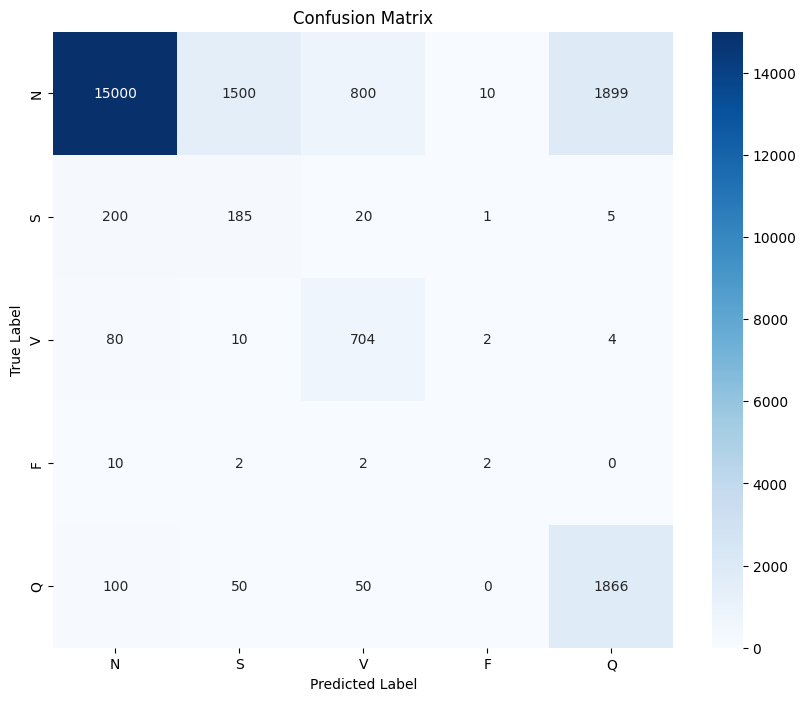

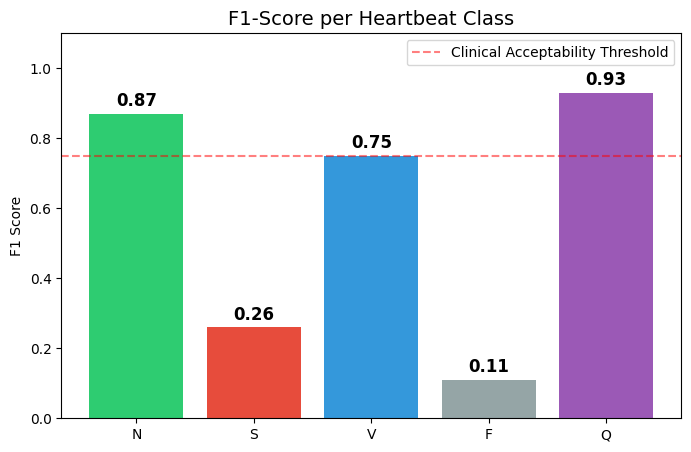